# Diagnostics for linear regression

In the previous sections, we've seen that under the assumption of the Gaussian model of linear regression, we can derive a number of useful tools for performing statistical inference on our fitted model, e.g. hypothesis tests on the coefficients.

However, these techniques were derived under a couple critical assumptions:

1. The true model is linear, i.e. there is a population parameter vector $\boldsymbol{\beta}$ such that $y = \boldsymbol{x}\cdot \boldsymbol{\beta} + \varepsilon$.
2. The errors $\varepsilon$ are independent and identically distributed (across observations) following a $N(0,\sigma^2)$ distribution with unknown variance $\sigma^2$.

If either of these assumptions are (significantly) violated, then the tests we developed in the previous section are meaningless. Hence it is important for us to develop methods to evaluate whether or not these assumptions (approximately) hold.

> We remark that in the previous paragraph, we condition our statements with words like "significantly" and "approximately". For data gathered in the real world, the assumptions 1 and 2 will almost never hold _exactly_, but provided they appear a reasonable model for the data we have in hand, we can still hope that the statistical tests we perform provide some usefulness; see the [famous quote](https://en.wikipedia.org/wiki/All_models_are_wrong) from the statistician George Box.

## QQ plots for assessing normality

One tool that is commonly used for visually evaluating whether the assumption of normal errors is approximately correct is a _quantile-quantile_ (or QQ) plot. A QQ plot works by plotting the quantiles of two distributions against each other; if the distributions are similar, the quantiles should appear to lie roughly on a line. In practice, QQ plots are typically made to compare the distribution of an empirical sample against a theoretical distribution which we hope our observations approximately follow.

In linear regression, we typically use QQ plots to evaluate the distribution of the residuals $r_i = y_i - \hat{y}_i$, where $\hat{y}_i$ is the fitted value from a regression model. If our model is correct, then the residuals should _approximately_ be distributed according to a $N(0,\sigma^2)$ distribution (though not exactly -- can you see why?).

Let's see a simple example with some simulated data where we compare the quantiles of data drawn from a standard normal distribution against the true quantiles of the standard normal. In python, QQ plots can easily be made using the `statsmodels` package. (Note that the default in the function below is to use the standard normal distribution as the theoretical distribution, so we don't need to specify any additional arguments.)

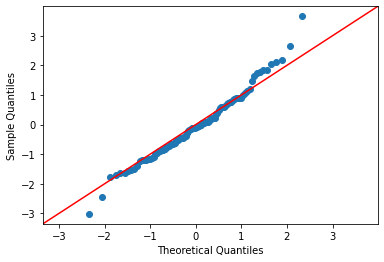

In [1]:
import statsmodels.api as sm
import numpy as np

n = 100
sample = np.random.normal(size=n)
fig = sm.qqplot(sample, line="45")

As we can see in the plot, the quantiles appear to lie almost exactly on the $y=x$ line, indicating that the samples seem to come from the standard normal distribution (which they do by design in this case). When applied to the residuals $r_i$, this raises an issue: we don't actually know the variance $\sigma^2$. Let's see what happens if we try the same plot as above, but draw samples instead from a normal distribution with a different variance.

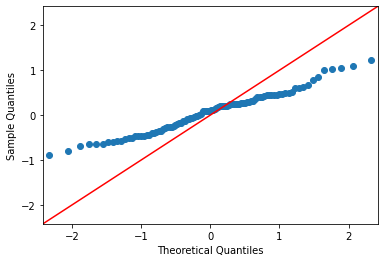

In [2]:
sample = 0.5*np.random.normal(size=n)
fig = sm.qqplot(sample, line="45")

Now the quantiles still appear to lie on a line, but not on the $y=x$ line. A simple way to try and correct for this is by considering the _standardized_ residuals $s_i = r_i/\hat{\sigma}$, where $\hat{\sigma}^2$ is our usual estimate of the residual variance. The `qqplot` function actually has an option to do this automatically for us, by setting `fit=True`:

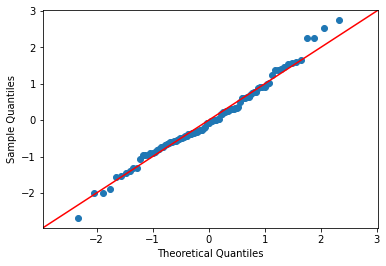

In [3]:
sample = 0.5*np.random.normal(size=n)
fig = sm.qqplot(sample, fit=True, line="45")

Now our quantiles again lie roughly on the $y=x$ line. The plot shown above is the one you will typically see reported as a diagnostic alongside a fitted linear regression model, though we should note that it is not quite accurate. Since we had to estimate the variance of the errors using $\hat{\sigma}$, it would really be more accurate to compare the quantiles of the standardized residuals to an appropriate $t$ distribution. This can also be done using the `statsmodels` function by specifying a target distribution. For example, the following compares the quantiles of the empirically standardized normal samples against a $t$ distribution with $n-1$ degrees of freedom.

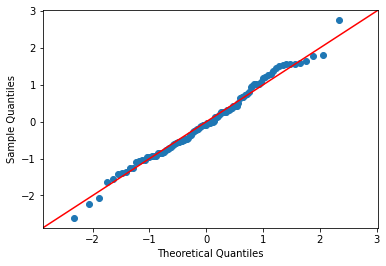

In [4]:
import scipy.stats as stats

sample = 0.5*np.random.normal(size=n)
fig = sm.qqplot(sample, dist=stats.t, distargs=(n-1,), fit=True, line="45")

While this is technically the more accurate thing to do, for $n$ reasonably large the distinction is often negligible, especially since these plots are typically used only as a visual diagnostic, rather than a formal statistcal test.

Let's see a few examples with an actual regression model. For this, we will use the urbanization vs GDP dataset.

In [5]:
import pandas as pd

dataset = pd.read_csv('datasets/urbanization-vs-gdp-2015.csv')
dataset.head()

,Unnamed: 0,country,percent_urban_pop,gdp_per_capita
0,66,Afghanistan,24.803,1928.0
1,585,Albania,57.434,10032.0
2,844,Algeria,70.848,14004.0
3,1476,Angola,63.446,8689.0
4,2121,Argentina,91.503,19502.0


Recall that for this dataset, the relationship between `percent_urban_pop` (the percent of the population living in urban areas) and `gdp_per_capita` appears to be monotonic but non-linear. However, this can be corrected by applying a log transformation to `gdp_per_capita`, as demonstrated by the following scatterplots.

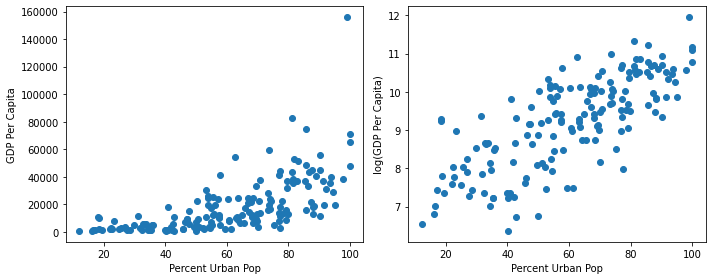

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

axs[0].scatter(dataset["percent_urban_pop"], dataset["gdp_per_capita"])
axs[0].set_xlabel("Percent Urban Pop")
axs[0].set_ylabel("GDP Per Capita")

axs[1].scatter(dataset["percent_urban_pop"], np.log(dataset["gdp_per_capita"]))
axs[1].set_xlabel("Percent Urban Pop")
axs[1].set_ylabel("log(GDP Per Capita)")

plt.tight_layout()
plt.show()

Let's fit linear regression to both the transformed and non-transformed datasets and see what the corresponding QQ plots show us. First we prep our data.

In [7]:
ones = np.ones(dataset.shape[0]).reshape(-1,1)
X = np.hstack([ones, dataset[["percent_urban_pop"]].to_numpy()])
y = dataset["gdp_per_capita"].to_numpy()
y_log = np.log(y)

Next, let's actually fit the models and get the fitted values $\hat{y}$.

In [8]:
beta_hat = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
beta_hat_transformed = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y_log))

y_hat = np.dot(X, beta_hat)
y_hat_transformed = np.dot(X, beta_hat_transformed)

To make the QQ plots, the last thing we need to do are compute the residuals.

In [9]:
r = y-y_hat
r_transformed = y_log-y_hat_transformed

Now we can make QQ plots for these two models.

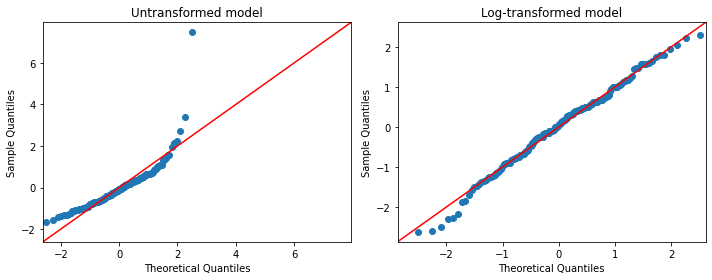

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

fig = sm.qqplot(r, fit=True, line="45", ax=axs[0])
axs[0].set_title("Untransformed model")

fig = sm.qqplot(r_transformed, fit=True, line="45", ax=axs[1])
axs[1].set_title("Log-transformed model")

plt.tight_layout()
plt.show()

From these plots we can see that the errors from the untransformed model do not appear to follow a normal distribution at all, as the residual quantiles vs the normal quantiles do not lie close to the $y=x$ line. On the other hand, for the log-transformed model the residuals look much better, closely matching the $y=x$ line. For the latter case, we may be confident that our assumption of normal errors (at least approximately) holds, and that we can apply our statistical tools to perform inference on such a model.

Before moving on to other diagnostic tools, let's inspect the non-transformed model a bit more closely. Note that the QQ plot here exhibits a "bent upward" trend; this corresponds to residuals which are skewed to the right. We can verify this by looking at a histogram of the residuals themselves:

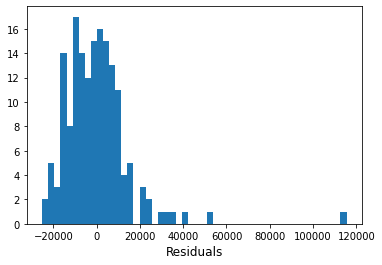

In [11]:
plt.hist(r, bins=50)
plt.xlabel("Residuals", fontsize=12)
plt.show()

Skewed residuals like this occur when a few observations have large positive deviations, i.e. the true $y$ value is much larger than the predicted $\hat{y}$. Can you think of why this might occcur for the GDP per capita data?

## Residual plots for assessing linearity

In addition to QQ plots, there are a number of other visual diagnostics that are often inspected after performing a regression analysis. Here, we will discuss one of these: namely a plot of the residuals verses the fitted values of the regression model.

Linearity is of course one of the key assumptions of fitting a linear regression model, i.e. that the observed data is generated by some (unknown) linear model of the form $y_i = \boldsymbol{\beta} \cdot \boldsymbol{x}_i+\varepsilon_i$. One way to check this assumption is by creating a plot of the residuals $r_i = y_i - \hat{y}_i$ versus the fitted values $\hat{y}_i$. If our assumption of linearity is correct, the this plot should look like points scattered around zero regardless of the value of $\hat{y}_i$. On the other hand, if this assumption is violated, then we should observe distinct deviations from zero that occur as a function of $\hat{y}_i$.

Let's use the two example models above for GDP per capita and urban population as an example to compute these plots.

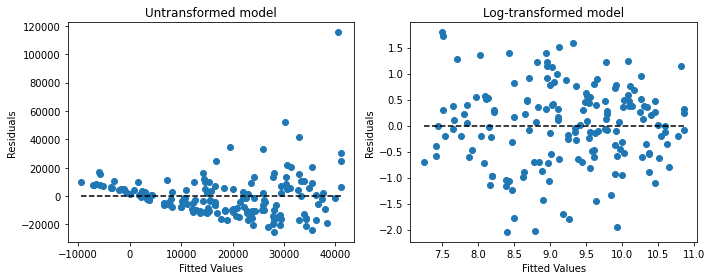

In [12]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

axs[0].scatter(y_hat, r)
axs[0].hlines(0, np.min(y_hat), np.max(y_hat), color='black', linestyle='--')
axs[0].set_xlabel("Fitted Values")
axs[0].set_ylabel("Residuals")
axs[0].set_title("Untransformed model")

axs[1].scatter(y_hat_transformed, r_transformed)
axs[1].hlines(0, np.min(y_hat_transformed), np.max(y_hat_transformed), color='black', linestyle='--')
axs[1].set_xlabel("Fitted Values")
axs[1].set_ylabel("Residuals")
axs[1].set_title("Log-transformed model")

plt.tight_layout()
plt.show()

The second plot (for the log-transformed models), perhaps unsurprisingly, looks good -- exactly what we'd expect if the true model is actually linear. Let us discuss the first plot, for the untransformed model, a bit more. Notice that for small value of $\hat{y}$, the residuals are almost exclusively positive, meaning that the model under-predicts for small values of $y$. If the true model were linear (with mean zero errors), we wouldn't expect this type of behavior.

> We remark that this plot is perhaps superfluous for the simple linear regression setting (with one predictor), since we could simply plot GDP per capita against percent urban population and see directly that the relationship between the two is not linear. However, as soon as we have more predictors, this becomes impossible. The benefit of using a residual vs predicted value plot is that it works _regardless of how many predictors we have_.

Note that it would also be perfectly reasonable to instead plot the observed values $y_i$ against the fitted $\hat{y}_i$'s; this would largely convey the same information as the residual vs fitted values plot. In this case, we would want the points to lie roughly on the $y=x$ line. However, it is standard practice to instead substract out the fitted values on the $y$-axis so that the points should lie around zero. For completeness, we show what this would look like in the following plots.

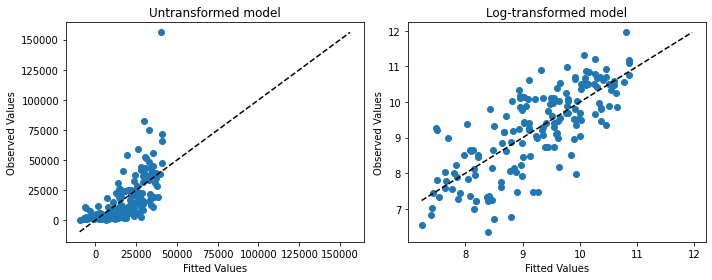

In [13]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs = axs.flatten()

axs[0].scatter(y_hat, y)
axs[0].plot([np.min(y_hat), np.max(y)], [np.min(y_hat), np.max(y)], color='black', linestyle='--')
axs[0].set_xlabel("Fitted Values")
axs[0].set_ylabel("Observed Values")
axs[0].set_title("Untransformed model")

axs[1].scatter(y_hat_transformed, y_log)
axs[1].plot([np.min(y_hat_transformed), np.max(y_log)], [np.min(y_hat_transformed), np.max(y_log)], color='black', linestyle='--')
axs[1].set_xlabel("Fitted Values")
axs[1].set_ylabel("Observed Values")
axs[1].set_title("Log-transformed model")

plt.tight_layout()
plt.show()

There are many other plots and diagnostics that are used to evaluate linear regression models; for example, a scale-location plot can be used to check whether the errors have the same variance across observations. In the homework, we will discuss concept called _leverage_, which is also an important tool for identifying outlier that significantly affect a regression model.